In [1]:
import numpy as np
import pandas as pd
import scipy.io as io
import os

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

torch.cuda.is_available()

True

In [3]:
class FNIRS_Dataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.targets = self.img_labels['Label']

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 4])
        image = np.float32(io.loadmat(img_path)['fnirsimg']).reshape(3,21,45)
        label = self.img_labels.iloc[idx, 5]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
train_data=FNIRS_Dataset(
    '../Label_TMB.csv',
    '../TMBData/'
)

In [5]:
from sklearn.model_selection import train_test_split

total_targets=torch.asarray(train_data.targets)
train_idx, valid_idx= train_test_split(
    np.arange(len(total_targets)), test_size=0.2, random_state=42, shuffle=True, stratify=total_targets)

train_set = torch.utils.data.Subset(train_data, train_idx)
#val_set = torch.utils.data.Subset(train_data, valid_idx)

train_sample_count = torch.tensor(
    [(total_targets[train_idx] == t).sum() for t in torch.unique(total_targets, sorted=True)])
train_weight = 1. / train_sample_count.float()
train_sample_weight = torch.tensor([train_weight[t] for t in total_targets[train_idx]])


In [6]:
total_targets.sum()

tensor(1912)

In [7]:
batch_size = 64

from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

# Creating PT data samplers and loaders:
train_sampler = WeightedRandomSampler(train_sample_weight, len(train_sample_weight))
# train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                                sampler=valid_sampler)

#train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [8]:
# Try to display each batch the imbalanced sample ratio

for i,(x,y) in enumerate(train_loader):
    if i <= 10:
        print("batch index {}, 0/1: {}/{}".format(
            i, (y==0).sum(),(y==1).sum()
        ))
    
    else:
        break


batch index 0, 0/1: 35/29
batch index 1, 0/1: 28/36
batch index 2, 0/1: 30/34
batch index 3, 0/1: 29/35
batch index 4, 0/1: 32/32
batch index 5, 0/1: 31/33
batch index 6, 0/1: 37/27
batch index 7, 0/1: 30/34
batch index 8, 0/1: 30/34
batch index 9, 0/1: 30/34
batch index 10, 0/1: 34/30


In [9]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 3, 21, 45])
Labels batch shape: torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


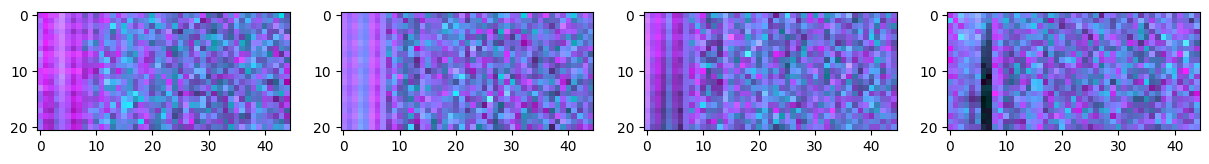

Label: (tensor(1), tensor(1), tensor(0), tensor(1))


In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,9))

img = train_features[5].squeeze()
label1 = train_labels[5]
plt.subplot(1,4,1)
plt.imshow(img.reshape(-1,45,3))

img = train_features[18].squeeze()
label2 = train_labels[18]
plt.subplot(1,4,2)
plt.imshow(img.reshape(-1,45,3))

img = train_features[48].squeeze()
label3 = train_labels[48]
plt.subplot(1,4,3)
plt.imshow(img.reshape(-1,45,3))

img = train_features[63].squeeze()
label4 = train_labels[63]
plt.subplot(1,4,4)
plt.imshow(img.reshape(-1,45,3))


plt.show()
print(f"Label: {label1, label2,label3,label4 }")

In [11]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [12]:
import timm

model = timm.create_model('resnet34', num_classes=2, pretrained=False)
x     = torch.randn(1, 3, 11, 45)
model(x)
model=model.to(device)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss

def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()     # Optional when not using Model Specific layer

    total_correct = 0
    total_instances = 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred,y)
        classifications = torch.argmax(model(X), dim=1)
        correct_predictions = sum(classifications==y).item()

        total_correct+=correct_predictions
        total_instances+=len(y)
            
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"val_loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    acc = total_correct/total_instances
    print(f"val_acc: {acc:>7f}")

    return loss, acc

In [19]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    validate(validation_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.532870  [   64/12182]


In [18]:
from tqdm.notebook import tqdm

def accuracy(network, dataset):
  """
  This function computes accuracy
  """
  #  setting model state
  network.eval()
  
  #  instantiating counters
  total_correct = 0
  total_instances = 0

  #  creating dataloader
  dataloader =dataset

  #  iterating through batches
  with torch.no_grad():
    for images, labels in tqdm(dataloader):
      images, labels = images.to(device), labels.to(device)

      #-------------------------------------------------------------------------
      #  making classifications and deriving indices of maximum value via argmax
      #-------------------------------------------------------------------------
      classifications = torch.argmax(network(images), dim=1)

      #--------------------------------------------------
      #  comparing indicies of maximum values and labels
      #--------------------------------------------------
      correct_predictions = sum(classifications==labels).item()

      #------------------------
      #  incrementing counters
      #------------------------
      total_correct+=correct_predictions
      total_instances+=len(images)
  return round(total_correct/total_instances, 3)

accuracy(model, validation_loader)

  0%|          | 0/48 [00:00<?, ?it/s]

0.868

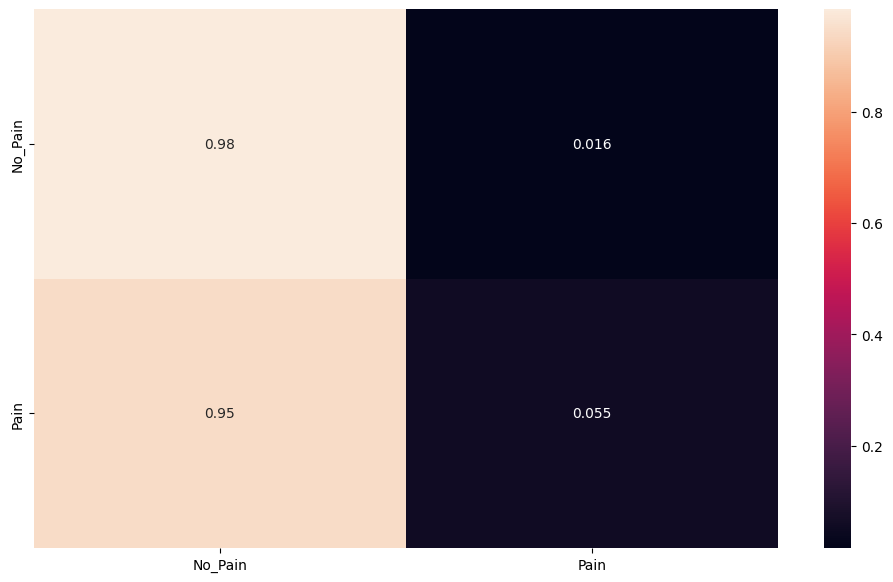

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []
y_true_roc = []

# iterate over test data
for inputs, labels in validation_loader:
        inputs=inputs.to(device)
        output = model(inputs) # Feed Network

        output = (torch.argmax(output, 1)).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        y_true_roc.extend((torch.softmax(model(inputs), 1)[:,1]).data.cpu().numpy())
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('No_Pain','Pain')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

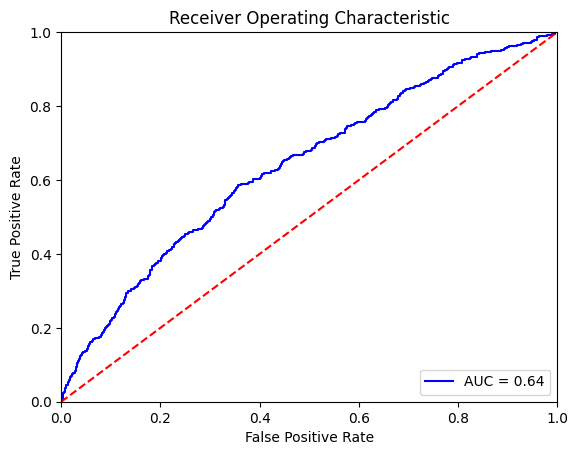

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold =roc_curve(y_true, y_true_roc)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'%roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
